# California Fishing / Wetfish

SST -> Landings using different pre-processing methods

Jonathan Falciani, 05/21/2025

In [1]:
from pyEDM import *

# Wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import re

# Stats
from itertools import permutations, combinations
import scipy.stats as sps
from pyunicorn.timeseries import Surrogates
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.optimize import curve_fit

# Processing
import multiprocessing
from tqdm import tqdm
from pathlib import Path
import sys
#from frozendict import frozendict

# Diagnostics
import os
import time
#import line_profiler

# Functions
sys.path.insert(0, str(Path.cwd().parent / "../scripts"))
%load_ext autoreload
%autoreload 2
from edm_funcs import *
from preprocessing_funcs import *

# Data loading

Using data imported as csv with dimensions [time, species, SST] with one column dedicated to timestep

In [2]:
dataname = 'cdfw_landingsALLunprocessed' + '_' + 'monthly'
#dataname = 'cdfw_landingsALLunprocessed' + '_' + 'seasonally'

filepath = os.getcwd().replace("scratch", "project")

data_input = pd.read_pickle(filepath + "/../../data_out/" + dataname + ".pkl")

data_input

,anchovy,bass,cabezon,croaker,crab_dungeness,crab_rock,crab_spider,flounder,grenadier,halibut,...,sole_rock,sole_sand,sole_unspecified,squid_market,thornyhead,tuna,whitefish_ocean,yellowtail,SURF_TEMP_C,BOT_TEMP_C
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,4448794,5035,5990,47377,4358429,102790,1825,36700,0,44136,...,0,38065,1305,3737800,283170,17932053,0,15396,14.640000,14.560000
1980-02-01,26614,6758,3341,74875,1071528,81545,904,34962,2218,36579,...,0,27656,306,1803245,395900,16221952,0,34233,15.255172,15.165517
1980-03-01,22323,4078,9118,100381,372448,97484,1295,58020,0,43117,...,0,20164,1065,0,208062,37865663,0,15749,15.875000,15.767857
1980-04-01,17639929,2461,1576,93150,393057,92055,0,41658,0,24011,...,0,11475,525,0,243988,78072280,0,20498,15.513793,15.196552
1980-05-01,16520436,6928,3026,144430,293073,99910,0,39771,0,48003,...,0,16864,1352,170805,125553,59768776,0,11121,16.377419,16.261290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,43930,0,4067,5383,0,108704,3457,1615,5764,162686,...,13,1797,0,4398528,22128,136090,1295,5897,22.516129,20.477419
2024-09-01,668853,0,5884,4925,0,83074,3137,1998,3715,121656,...,0,1464,0,2002935,25635,132001,3216,1399,20.922727,19.695455
2024-10-01,197337,0,4265,2247,0,75621,4525,1522,0,114876,...,102,2675,0,12260188,20563,100007,4641,975,18.022581,16.760000


# Functions

In [3]:
# Placeholder CCM and surrogate functions
def ccm_test(df, A, B, E=3, tau=-1, theta=0, Tp=1, exclusionRadius=12, libsizes='', convergence=True):
    lib_all = '1 '+str(len(df)); pred = lib_all

    out = CCM(
        dataFrame=df,
        columns=A, target=B, 
        libSizes=libsizes,
        sample=100,
        exclusionRadius=exclusionRadius,
        E=E, tau=tau, Tp=Tp,
        includeData=True
    )
    rho = out['LibMeans'].iloc[-1,1] # Last row, second column (i.e., the average last rho value)
    auc = np.trapz(out['LibMeans'].iloc[:,1], out['LibMeans'].iloc[:,0])

    if convergence == True:
        ccm_curve = fit_ccm_curve(out['LibMeans'], ab_col=A+':'+B, plot=False)
        convergence = has_converged(ccm_curve)
        rho_conv = ccm_curve['rho_conv']
    else:
        convergence = np.nan; rho_conv = np.nan
        #convergence_t_stat = np.nan; convergence_p_value = np.nan; lib_diff = np.nan

    return rho, auc, rho_conv, convergence, # rho: strength; auc: strength2; rho_conv: converged strength; convergence: boolean


def find_best_param(df, A, B, E_range=range(2, 7), tau_range=range(-3, 0), theta_range=np.linspace(0, 8, 17), Tp=1):
    """
    Finds the (E, tau, theta) combination that yields the highest correlation (rho) between Observations and Predictions using Smap.

    Args:
        df: pandas DataFrame with required columns.
        A, B: column names for driver and target.
        E_range: iterable of embedding dimensions to test.
        tau_range: iterable of tau values to test.
        theta_range: iterable of theta values to test.
        Tp: prediction horizon.

    Returns:
        best_E, best_tau, best_theta
    """
    best_E=E_range[0]; best_tau=tau_range[0]; best_theta=theta_range[0]; best_rho=0  # Allow negative correlations if needed

    lib_all = '1 ' + str(len(df))
    pred = lib_all

    for E in E_range:
        for tau in tau_range:
            for theta in theta_range:
                smap = SMap(
                    dataFrame=df,
                    columns=A, target=B,
                    lib=lib_all, pred=pred,
                    exclusionRadius=np.abs(E*tau),
                    E=E, tau=tau, Tp=Tp, theta=theta
                )
                rho = smap['predictions'][['Observations', 'Predictions']].corr().iloc[0, 1]
                if rho is not None and np.isfinite(rho) and rho > best_rho:
                    best_rho=rho; best_E=E; best_tau=tau; best_theta=theta
    return best_E, best_tau, best_theta

In [4]:
def CCM_fw(interaction, data, output, num_trials=100, Erange=range(1,12), taurange=range(-3,0), thetarange=np.linspace(0, 8, 17), Tp=1, nonlinear=True):
    '''
    This function calculates the CCM value, convergence p-value, seasonal shuffled average, 95% and 99% values, 
    and CCM significance over time for a directional link between two species (from species A to B).
    
    INPUT  interaction : a tuple of two species (A, B)
           data        : a dataframe with a time column and species columns
           num_trials  : number of surrogate trials to run
           E           : embedding dimension of interaction
           tau         : time lag used to create embedding
           Tp          : prediction interval
           randomize   : "monthly" for seasonal surrogates, any other value for random surrogates
                
    OUTPUT A dictionary with the following elements:
           target              : species A (causal driver)
           lib                 : species B (driven variable)
           convergence p-value : p-value from one-tailed t-test between 20% library size and 50% library size (50 trials)
           ccm rho             : CCM value for causal link from species A to B
           average_trials_rho  : average rho of surrogate trials
           p95_trials_rho      : 95th percentile of surrogate trials
           p99_trials_rho      : 99th percentile of surrogate trials
           ccm_over_time       : ccm significance over time
    '''
    
    # Get dataframe with two species of interest
    A = interaction[0]; B = interaction[1]
    df = data[['time', A, B]]
    
    # find the best set of parameters
    if nonlinear == True:
        best_E, best_tau, best_theta = find_best_param(
            df, A, B,
            E_range=Erange,
            tau_range=taurange,
            theta_range=thetarange,
            Tp=Tp
        )
    elif nonlinear == False: # if want linear model (order-E autoregressive model, AR)
        best_E, best_tau, best_theta = find_best_param(
            df, A, B,
            E_range=Erange,
            tau_range=taurange,
            theta_range=[0,0],
            Tp=Tp
        )

    # Convergence Check: Does CCM prediction converge over different library sizes?
    # Main CCM Analysis: What is the EDM prediction of B's effect on A?
    libsize_small, libsize_large = int(round( 0.05*len(df) )), int(round( 0.8*len(df) )) # 10% to 80% libsizes of df
    libsize_inc = max(1, int(round((libsize_large - libsize_small)/9))) # 10 point increment
    libsizes = f"{libsize_small} {libsize_large} {libsize_inc}"

    excluR = np.abs(best_E * best_tau)
    
    # Original
    rho, auc, rho_conv, convergence = ccm_test(df, A, B, E=best_E, tau=best_tau, theta=best_theta, Tp=Tp, exclusionRadius=excluR, libsizes=libsizes, convergence=True)

    
    # Randomize Library Trials: Is the prediction robust against surrogate shuffling of seasons/timesteps?
    if convergence == True:
        # Surrogates
        num_trials = 100
        rho_trials = np.zeros(num_trials)
        auc_trials = np.zeros(num_trials)
        rhoconv_trials = np.zeros(num_trials)
        conv_trials = np.zeros(num_trials)
        
        for trial in range(num_trials):
            xs, ys = surrogates_seasonal_pair(df[A], df[B], ns=1, mode="within_phase", period=12, verbose=False)
            df_surr = df.copy()
            df_surr[A] = xs[0]  # keeps original 'A' intact; 'A_surr' holds the shuffled series
            df_surr[B] = ys[0]  # keeps original 'A' intact; 'A_surr' holds the shuffled series
        
            rho_trials[trial], auc_trials[trial], rhoconv_trials[trial], conv_trials[trial] = ccm_test(df_surr, A, B, E=best_E, tau=best_tau, theta=best_theta, Tp=Tp, exclusionRadius=excluR, libsizes=str(int(round( 0.8*len(df) ))), convergence=False)

        rho_trial_mean = np.mean(rho_trials)
        rho_trial_p95 = np.percentile(rho_trials, 95)
        rho_trial_p99 = np.percentile(rho_trials, 99)
        
        p_rho = empirical_p(rho, rho_trials, tail="greater")
        p_auc = empirical_p(auc, auc_trials, tail="greater")

    else:
        rho_trial_mean = np.nan
        rho_trial_p95 = np.nan
        rho_trial_p99 = np.nan
        
        p_rho = np.nan
        p_auc = np.nan
    
    # Preparing Output
    output = {
        'lib': A,
        'target': B,
        'Tp': Tp,
        'E': best_E,
        'tau': best_tau,
        'theta': best_theta,
        'ccm_rho': rho,
        #'ccm_auc': auc,
        'convergence': convergence,
        'ccm_norm': rho - rho_trial_mean,
        'trial_rho95p': rho_trial_p95,
        'trial_rho99p': rho_trial_p99,
        'p_rho': p_rho#,
        #'p_auc': p_auc
    }

    return output


def identify_resolved_interactions(df):
    '''
    This function adds a 'resolved' column to the dataframe, marking interactions as True if they satisfy 
    significance conditions, and False otherwise.
    
    A link is considered significant if:
        - The convergence p-value is < 0.05 AND
        - The CCM rho is greater than the 95th percentile rho of the surrogate shuffled trials.
    '''
    df = df.copy()  # Avoid modifying the original dataframe
    
    # Define the condition
    df['resolved_nonlinear'] = (df['convergence'] == True) & (df['p_rho'] < 0.05)  
    #df['resolved_linear'] = (df['convergence_linear'] == True) & (df['p_rho_linear'] < 0.05) 
    
    return df

# Running

In [5]:
# A) Keep seasonality, remove trend (good when trophic signal is seasonal)
anoms_trendless = detrend_stl(data_input.drop(columns=['time','Date'], errors='ignore'), period=4, keep_seasonal=True)

# B) Remove trend + seasonality (pure residuals)
residuals_stl = detrend_stl(data_input.drop(columns=['time','Date'], errors='ignore'), period=4, keep_seasonal=False)

# C) Linear (or polynomial) detrend only
anoms_linear = detrend_linear(data_input.drop(columns=['time','Date'], errors='ignore'))
anoms_poly   = detrend_poly(data_input.drop(columns=['time','Date'], errors='ignore'), degree=2)

# D) HP-filter detrend (choose lambda to your cadence)
anoms_hp = detrend_hp(data_input.drop(columns=['time','Date'], errors='ignore'), lamb=1600)  # monthly

# E) LOWESS trend removal (flexible smooth trend)
anoms_loess = detrend_loess(data_input.drop(columns=['time','Date'], errors='ignore'), frac=0.25)

# F) Seasonal differencing (removes repeating cycle, keeps regime shifts)
anoms_sdiff = seasonal_diff(data_input.drop(columns=['time','Date'], errors='ignore'), period=4).dropna()


## Preprocessing
data = anoms_trendless.copy() # Copy data of interest here
data = normalize_df(data, method="zscore", log1p_cols=None, exclude=("time", "Date"))

data['time'] = data.reset_index().index
last_col = data.iloc[:, -1] # Extract the last column
data = data.iloc[:, :-1] # Delete the last column
data.insert(0, last_col.name, last_col) # Insert the last column as the first column
df = data.copy()

df = df.reset_index() # Step 1: Reset *all* index levels to columns
if isinstance(df.columns, pd.MultiIndex): # Step 2 (optional): Flatten column index if it's a MultiIndex; This happens often after pivot tables or groupbys with multiple levels
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
data = df.drop("Date", axis=1)

data

,time,anchovy,bass,cabezon,croaker,crab_dungeness,crab_rock,crab_spider,flounder,grenadier,...,sole_rock,sole_sand,sole_unspecified,squid_market,thornyhead,tuna,whitefish_ocean,yellowtail,SURF_TEMP_C,BOT_TEMP_C
0,0,-6.056120,1.186655,0.044747,-0.824065,0.890469,0.633994,0.116510,0.876484,-0.051593,...,-0.243892,1.748502,0.795075,-0.070762,0.011014,-10.630238,-0.179245,-0.963696,-0.128623,-0.256829
1,1,-5.668148,3.738519,-0.395219,0.456221,-0.576784,-0.659051,-0.219862,-0.202790,0.037830,...,-0.238703,0.288634,-0.217336,-0.205011,0.897009,-10.973313,-0.175188,0.767558,0.036331,0.032387
2,2,-4.166670,0.460613,0.732345,1.632684,-0.834197,0.209521,0.181099,0.489198,-0.037935,...,-0.234084,-0.783112,-0.099163,-0.336726,-0.613041,-6.689708,-0.173026,-0.642632,0.205365,0.324974
3,3,1.776316,-1.412889,-0.624101,1.096866,-0.755068,-0.152303,-0.393246,-1.632677,-0.031447,...,-0.229631,-2.018098,-0.821567,-0.324946,-0.314677,1.272239,-0.172533,-0.096813,-0.507403,-0.509362
4,4,2.996713,4.747858,-0.312377,3.612193,-0.733564,0.248666,-0.243312,-2.702327,-0.023998,...,-0.225724,-1.371276,-0.725774,-0.306387,-1.242667,-2.358478,-0.172135,-0.739780,-0.115405,0.253339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,535,-0.052841,-0.214230,-0.314908,-0.009733,-0.376004,1.004954,-0.173245,-0.062603,0.036131,...,-0.235362,0.004060,-0.145404,-1.328612,-0.042091,0.057318,-1.716027,-0.009727,3.699116,2.653338
536,536,0.102945,-0.222316,0.106457,0.007087,-0.367399,-0.093267,-0.533205,-0.029160,0.008559,...,-0.259415,-0.030289,-0.141231,-1.769640,-0.024148,0.056864,0.044076,-0.319788,2.607294,2.397573
537,537,-0.017244,-0.261731,-0.116367,-0.089171,-0.359809,-0.117985,0.075914,-0.054533,-0.079626,...,-0.185547,0.145216,-0.137520,-1.153218,-0.075985,0.051161,1.173006,-0.264293,0.377671,0.039978
538,538,-0.063306,-0.311760,-0.105649,-0.136769,-0.353155,-0.421326,0.333338,-0.147841,-0.026720,...,-0.257494,-0.104711,-0.133681,0.792427,-0.066392,0.048073,-0.368720,-0.146341,-1.134467,-0.956673


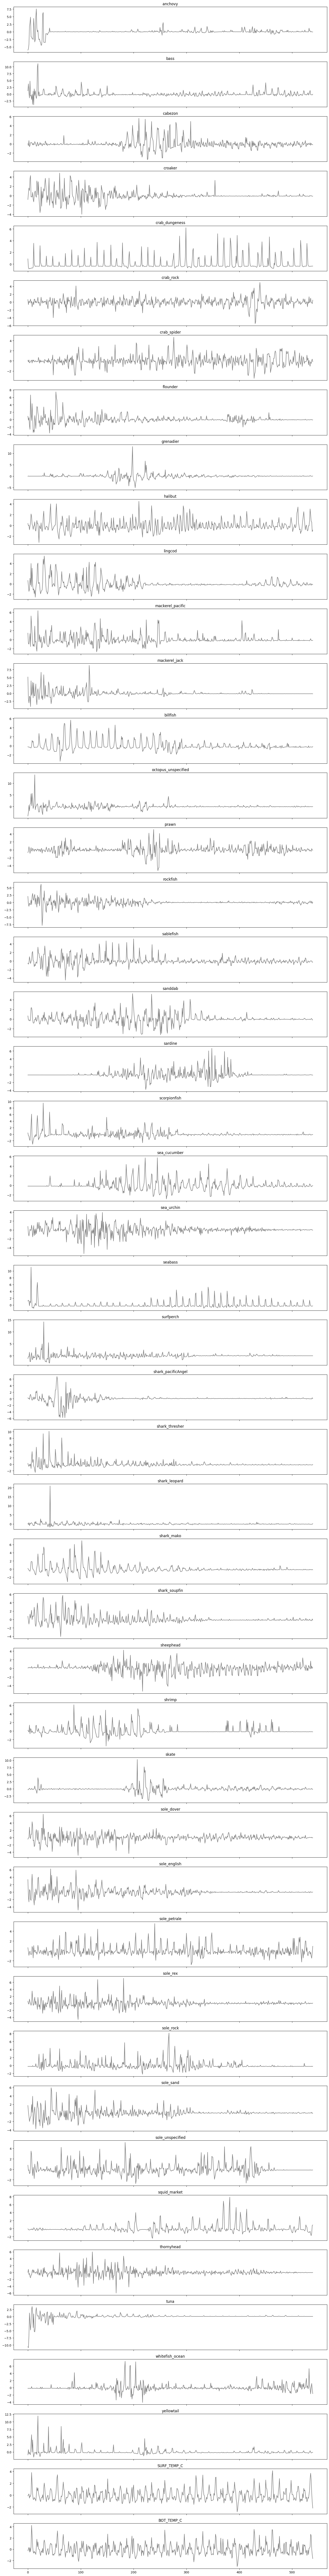

In [8]:
# Assume `data` has columns: 'time', and one column per management plan
n_series = data.shape[1] - 1  # number of time series (excluding 'time')

fig, axes = plt.subplots(n_series, sharex=True, figsize=(15, 2.5 * n_series))

if n_series == 1: # If only one subplot, put axes in a list to keep code uniform
    axes = [axes]

for i, col in enumerate(data.columns[1:]): # Loop through each timeseries column (skipping 'time')
    axes[i].plot(data[col], color='gray')
    axes[i].set_title(col)
    #axes[i].grid(True)

plt.tight_layout()
plt.show()

In [9]:
interactions = list(permutations(data.columns[1:], 2))

#cols = data.columns[1:]
#interactions = [
#    pair for pair in permutations(cols, 2)
#    if 'SURF_TEMP_C' in pair
#]

#cols = data.columns[1:]
#interactions = [
#    pair for pair in permutations(cols, 2)
#    if pair[1] == 'SURF_TEMP_C'
#]

In [10]:
# Parameters
num_trials = 100
Erange = range(2,7) #range(3,4) 
taurange = range(-3,0) #range(-1,0) 
thetarange = np.linspace(0, 8, 17)
Tp = 1
nonlinear = True

output = {} # predetermine empty dict that output gets written to
interaction_is = range(len(interactions)) # interaction indices to run over #range(9,18)

args_nonlinear = [ (interactions[i], data, output, num_trials, Erange, taurange, thetarange, Tp, True) for i in interaction_is ] # predetermining the arguments that get fed into CCM_fw()
#args_linear = [ (interactions[i], data, output, num_trials, Erange, taurange, thetarange, Tp, False) for i in interaction_is ] # predetermining the arguments that get fed into CCM_fw()

In [90]:
t0 = time.time()

with multiprocessing.Pool(processes=64) as pool:
    # Run the fill_dictionary function in parallel for each index
    ccm_results_nonlinear = pool.starmap(CCM_fw, args_nonlinear)
    #ccm_results_linear = pool.starmap(CCM_fw, args_linear)

ccm_results_nonlinear = pd.DataFrame(ccm_results_nonlinear)
#ccm_results_linear = pd.DataFrame(ccm_results_linear)

t1 = time.time()
print("Time: " + str(round(t1-t0, 2)) + "s" + " (" + str(round((t1-t0) / 60 / 60, 2)) + "h)")

Time: 5363.71s (1.49h)


In [91]:
# Combine
#ccm_results_linear = ccm_results_linear.add_suffix('_linear')

# Merge the two dataframes on their index or a common key column
#ccm_results = ccm_results_nonlinear.merge(
#    ccm_results_linear, 
#    left_index=True,  # Use index if applicable
#    right_index=True,  # Use index if applicable
#    how='left'  # Ensures all rows from ccm_results_nonlinear are preserved
#)

ccm_results = ccm_results_nonlinear.copy()

In [92]:
# Apply the function
results_significant = identify_resolved_interactions(ccm_results)
results_significant

,lib,target,Tp,E,tau,theta,ccm_rho,convergence,ccm_norm,trial_rho95p,trial_rho99p,p_rho,resolved_nonlinear
0,anchovy,bass,1,4,-2,1.0,0.096296,False,NaN,NaN,NaN,NaN,False
1,anchovy,cabezon,1,6,-1,4.5,0.204746,True,0.156294,0.123715,0.137749,0.009901,True
2,anchovy,croaker,1,4,-3,1.5,0.157301,True,0.151656,0.094478,0.153288,0.019802,True
3,anchovy,crab_dungeness,1,3,-3,6.0,0.108320,True,0.026785,0.234305,0.267210,0.267327,False
4,anchovy,crab_rock,1,4,-1,1.0,0.016111,False,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,BOT_TEMP_C,thornyhead,1,5,-1,2.0,0.076434,True,0.026303,0.120276,0.132341,0.297030,False
2158,BOT_TEMP_C,tuna,1,5,-3,0.0,0.067831,False,NaN,NaN,NaN,NaN,False
2159,BOT_TEMP_C,whitefish_ocean,1,2,-1,8.0,0.155142,False,NaN,NaN,NaN,NaN,False
2160,BOT_TEMP_C,yellowtail,1,6,-2,1.0,0.148852,False,NaN,NaN,NaN,NaN,False


# Plotting Check

/tmp/ipykernel_1209245/948969519.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  significant_bool = pivot_significant.fillna(False).astype(bool)


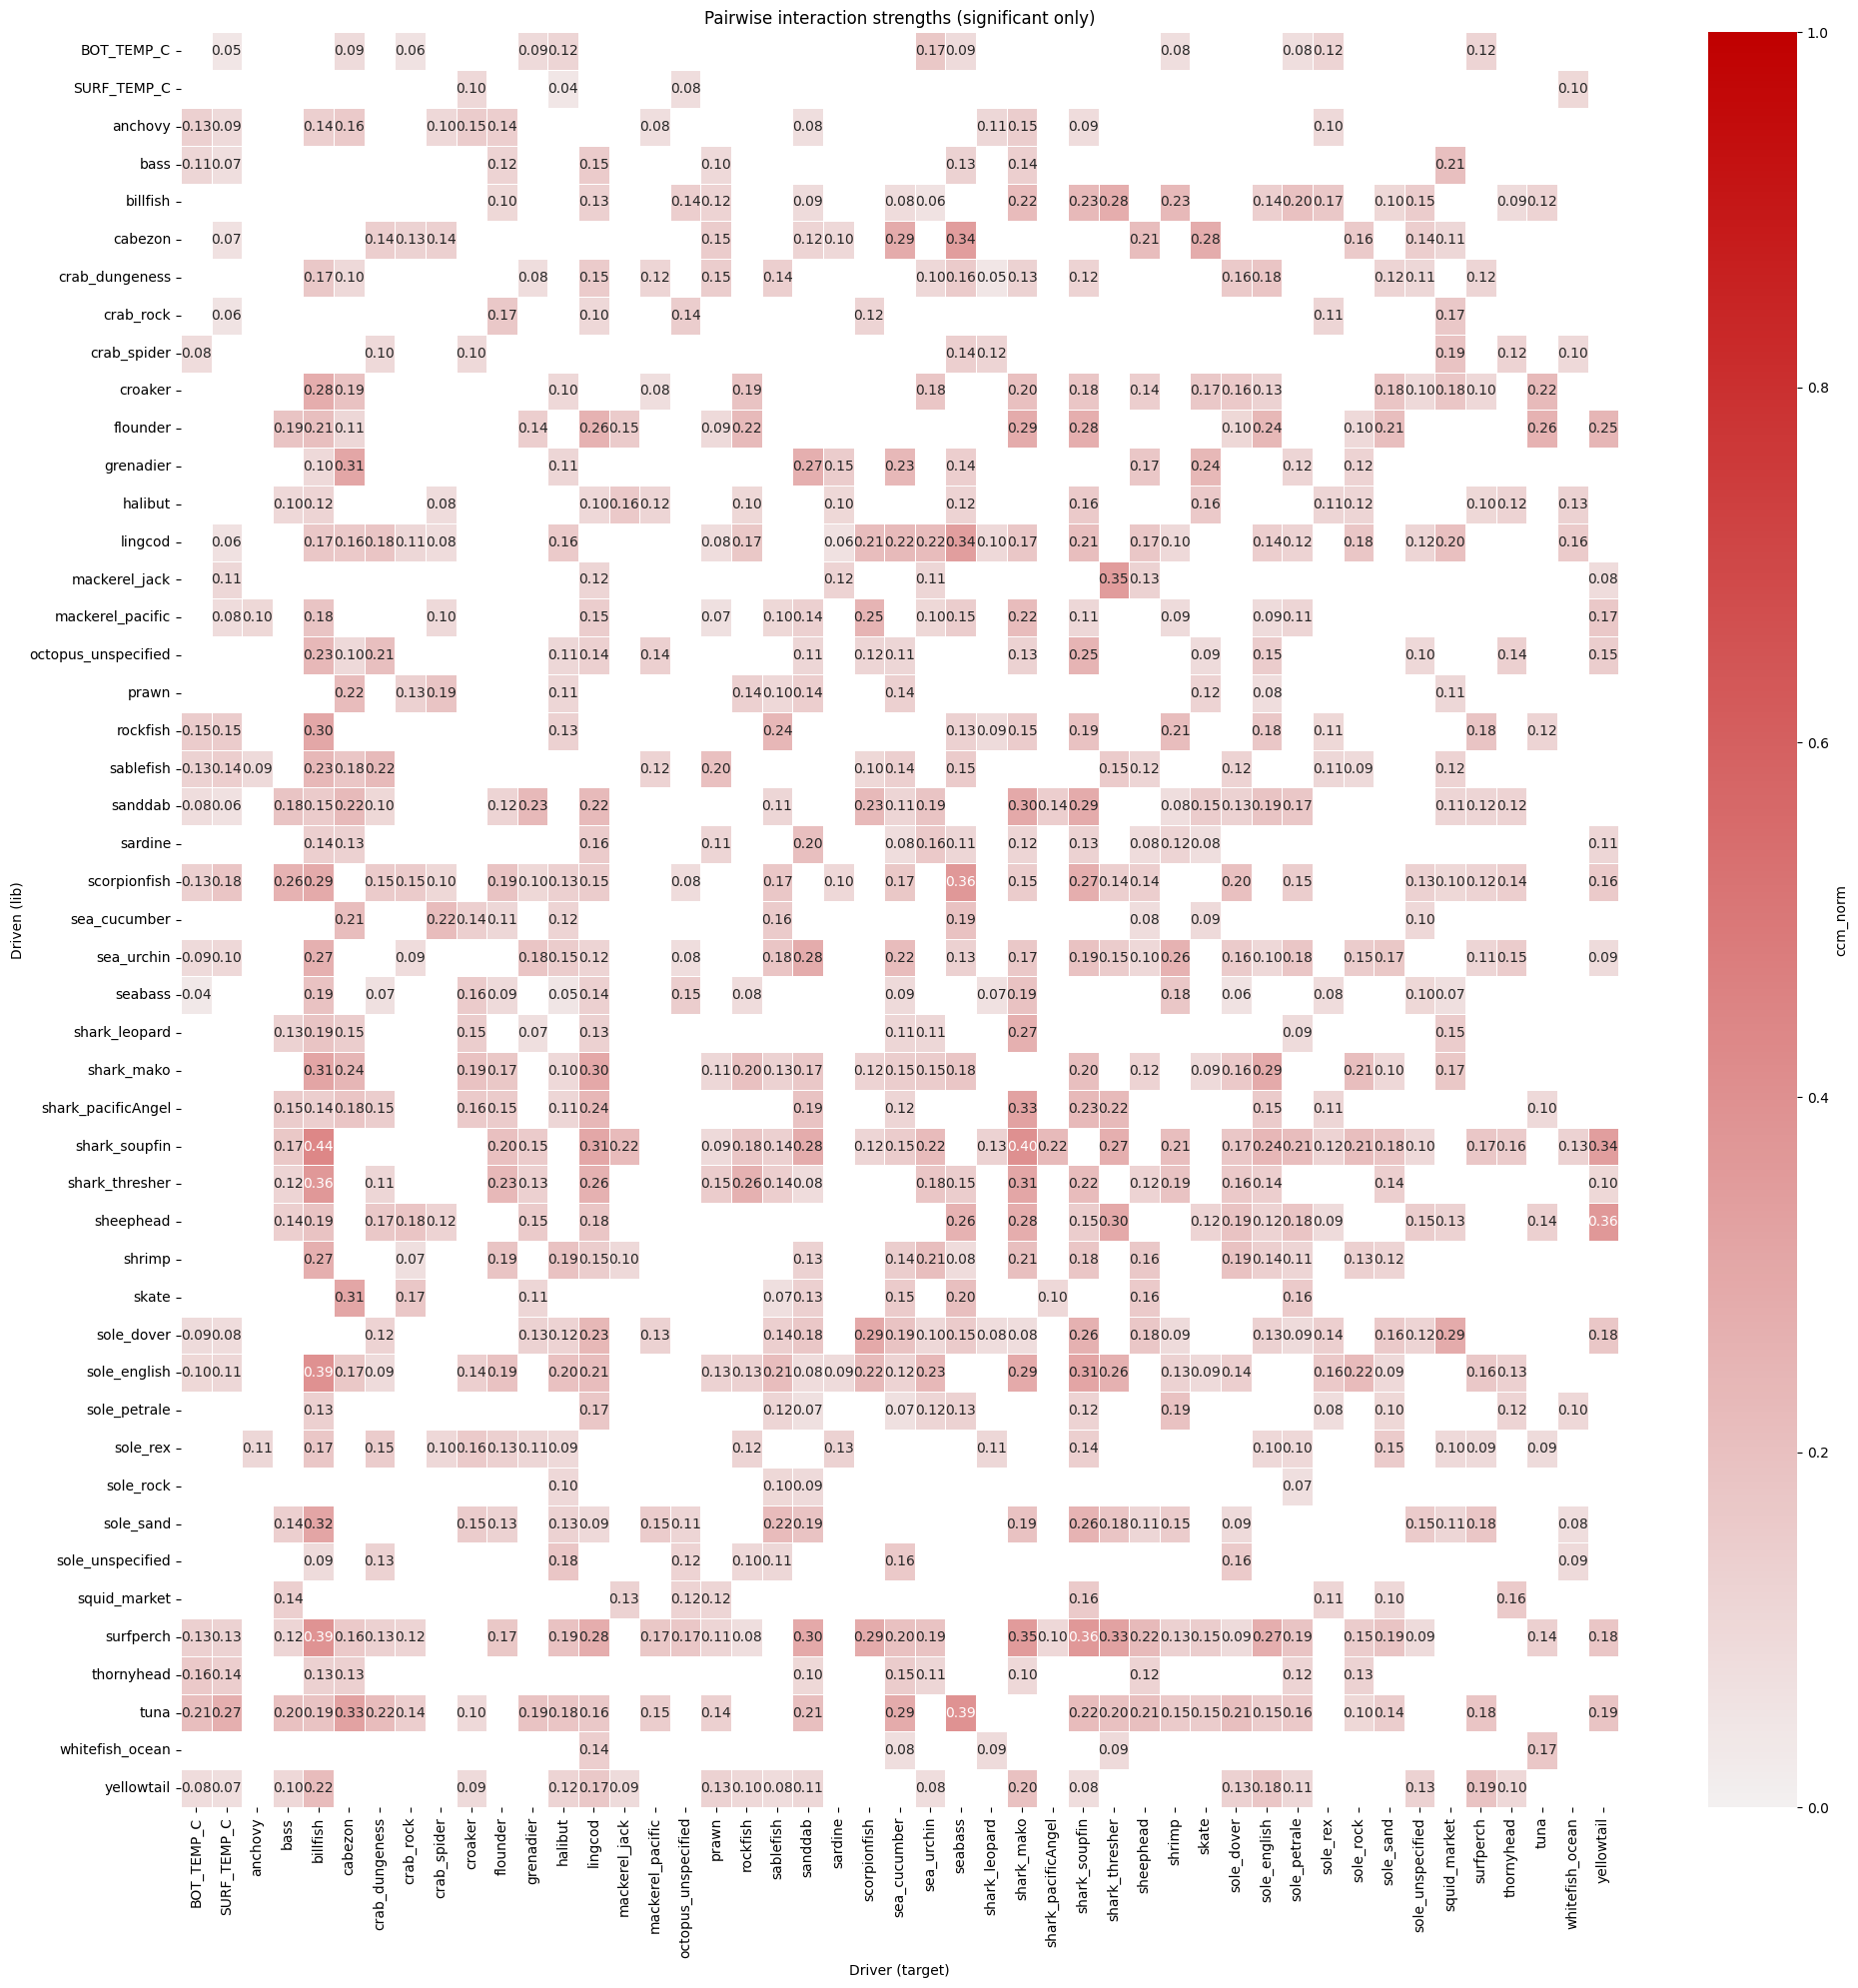

In [101]:
# === PARAMETERS ===
# Choose whether you're using nonlinear or linear results
#correlation_col = 'smap_rho'           # or 'smap_rho_linear'
correlation_col = 'ccm_norm' 
#correlation_col = 'average_trials_rho'
significance_col = 'resolved_nonlinear'  # or 'resolved_linear'

# === BUILD PIVOT TABLE OF CORRELATIONS ===
# Create a pivot table with driver on x-axis, driven on y-axis
pivot_rho = results_significant.pivot(index='lib', columns='target', values=correlation_col)
pivot_significant = results_significant.pivot(index='lib', columns='target', values=significance_col)

# Create a masked version for coloring only significant values
significant_bool = pivot_significant.fillna(False).astype(bool)
# Mask insignificant correlations
masked_rho = pivot_rho.copy()
masked_rho[~significant_bool] = np.nan

# === PLOT ===
#plt.figure(figsize=(10, 8))
plt.figure(figsize=(20, 20))
sns.heatmap(
    masked_rho,
    #cmap='coolwarm',
    #vmin=-1, vmax=1,
    cmap=sns.light_palette("#C00000", as_cmap=True),
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': correlation_col}
)

# Optional: overlay a gray grid for insignificant values
#gray_mask = ~pivot_significant
#for y in range(pivot_rho.shape[0]):
#    for x in range(pivot_rho.shape[1]):
#        if gray_mask.iloc[y, x]:
#            plt.gca().add_patch(plt.Rectangle((x, y), 1, 1, color='lightgray', zorder=0))

plt.title('Pairwise interaction strengths (significant only)')
plt.xlabel('Driver (target)')
plt.ylabel('Driven (lib)')
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'predictions_linear'

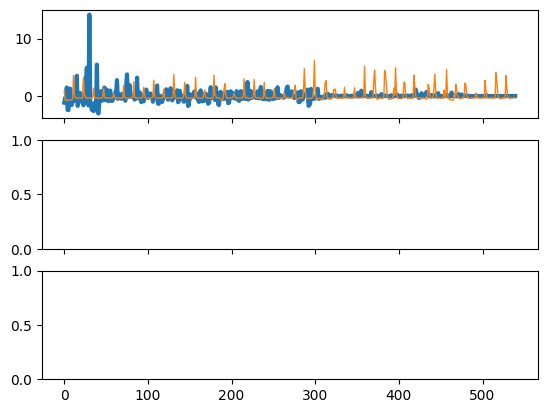

In [96]:
row = np.random.randint(0, len(results_significant))
target = str(results_significant.target[row])
lib = str(results_significant.lib[row])

fig, [ax1, ax2, ax3] = plt.subplots(3, sharex=True)

ax1.plot(data['time'], data[target], linewidth=3)
#ax1.plot(data['time'], data[lib], linewidth=3)
ax1.plot(data['time'], data[lib], linewidth=1)
ax1.plot(results_significant.predictions_linear[row]['time'], results_significant.predictions_linear[row]['Predictions'], linestyle='dotted', color='tab:blue')
ax1.plot(results_significant.predictions[row]['time'], results_significant.predictions[row]['Predictions'], linestyle='dashed', color='tab:blue')
ax1.axvspan(0, results_significant.predictions[row]['time'].min(), alpha=0.5, color='gray')
ax1.legend(["target (driver): " + str(results_significant.iloc[row,]["target"]),
            "lib (driven): " + str(results_significant.iloc[row,]["lib"]),
           "Smap rho (linear): ρ = " + f"{results_significant.smap_rho_linear[row] :.3f}" + (" *" if results_significant.resolved_linear[row] else ""),
            "Smap rho (nonlinear): ρ = " + f"{results_significant.smap_rho[row] :.3f}" + (" *" if results_significant.resolved_nonlinear[row] else "")
           ])
#ax1.set_ylim(-0.05, 1.05)
#ax1.set_ylim(-2.5, 2.5)
#ax1.set_ylim(10, 25)
ax1.set_title("Normalized species abundance" +" ("+dataname+ ")")

ax2.plot(results_significant.ccm_over_time[row]['time'], results_significant.ccm_over_time[row]['CCM_over_time_significance'], color="black",
    #label = "Smap rho (linear): ρ = " + f"{results_significant.smap_rho_linear[row] :.3f}\n" + "Smap rho (nonlinear): ρ = " + f"{results_significant.smap_rho[row] :.3f}"
        label = "theta: " + f"{results_significant.theta[row] :.3f}"
        )
ax2.axhline(y=0.05, color='gray', linestyle='dotted')
ax2.axvspan(0, results_significant.ccm_over_time[row]['time'].min(), alpha=0.5, color='gray')
ax2.set_xlim(0, len(data['time'])-1)
ax2.set_ylim(-0.05, 1.05)
ax2.legend()
ax2.set_title("SMap error over time" +" ("+dataname+ ")")

ax3.plot(results_significant.smap_coeff[row]['time'], results_significant.smap_coeff[row]['coeff'],
         color="black",
         alpha=0.2)
ax3.plot(results_significant.smap_coeff[row]['time'], results_significant.smap_coeff[row]['coeff_error'],
         color="black",
         marker = ".",
         label = "CCM rho: ρ = " + f"{results_significant.ccm_rho[row] :.3f}")
ax3.axhline(y=0, color='gray', linestyle='dotted')
ax3.axvspan(0, results_significant.smap_coeff[row]['time'].min(), alpha=0.5, color='gray')
#ax3.set_ylim(-1.05, 1.05)
ax3.legend()
ax3.set_title("SMap over time" +" ("+dataname+ ")")

fig.set_size_inches(15, 8)
plt.tight_layout()
plt.show()


df_coeff_driver = pd.merge(results_significant.smap_coeff[row], data[['time', target]], on='time', how='inner')
fig, ax0 = plt.subplots(1, sharex=False)
ax0.plot(df_coeff_driver[target], df_coeff_driver['coeff'], color='gray', linewidth=0.2, alpha=0.5, zorder=1)
sc = ax0.scatter(df_coeff_driver[target], df_coeff_driver['coeff'], 
            #color='black',
            c=df_coeff_driver['time'], cmap='viridis',
            s=2,
           zorder=2)
ax0.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax0.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax0.set_title("Coefficient vs. driver: " + ("norm_val (nonlin) ρ = " + f"{results_significant.smap_rho[row] :.3f}") + (" *" if results_significant.resolved_nonlinear[row] else ""))
ax0.set_ylabel("SMap Coeff." + " on " + str(lib))
ax0.set_xlabel(target)
cbar = plt.colorbar(sc, ax=ax0) # Colorbar for time gradient
cbar.set_label('Time')

fig.set_size_inches(5, 3.5)
plt.tight_layout()
plt.show()

In [ ]:
filtered_df = results_significant[(results_significant['target'] == 'SURF_TEMP_C') & (results_significant['resolved_nonlinear'] == True)].reset_index(drop=True)
row = np.random.randint(min(filtered_df.index), max(filtered_df.index))
target = str(filtered_df['target'][row])
lib = str(filtered_df.lib[row])

df_coeff_driver = pd.merge(filtered_df.smap_coeff[row], data[['time', target]], on='time', how='inner')

fig, ax0 = plt.subplots(1, sharex=False)

ax0.plot(df_coeff_driver[target], df_coeff_driver['coeff'], color='gray', linewidth=0.2, alpha=0.5, zorder=1)
sc = ax0.scatter(df_coeff_driver[target], df_coeff_driver['coeff'], 
            #color='black',
            c=df_coeff_driver['time'], cmap='viridis',
            s=2,
           zorder=2)
ax0.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax0.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax0.set_title("Coefficient vs. temperature: " + ("norm_val (nonlin) ρ = " + f"{filtered_df.norm_val[row] :.3f}") + (" *" if filtered_df.resolved_nonlinear[row] else ""))
ax0.set_ylabel("SMap Coeff." + " on " + str(lib))
ax0.set_xlabel(target)
cbar = plt.colorbar(sc, ax=ax0) # Colorbar for time gradient
cbar.set_label('Time')

fig.set_size_inches(5, 3.5)
plt.tight_layout()
plt.show()

In [ ]:
#x1s = 'smap_rho_linear'
#y1s = 'smap_rho'
x1s = 'norm_val_linear'
y1s = 'norm_val'

# Define significance categories
def categorize(row):
    if row['resolved_nonlinear'] and row['resolved_linear']:
        return 'Both'
    elif row['resolved_nonlinear']:
        return 'Nonlinear only'
    elif row['resolved_linear']:
        return 'Linear only'
    else:
        return 'Neither'

filtered_data = results_significant.dropna(subset=[x1s, y1s, 'theta'])
filtered_data['Significance'] = filtered_data.apply(categorize, axis=1)
filtered_data = filtered_data[filtered_data["Significance"] != "Neither"] # Comment if want the insignificant interactions

# Marker mapping for significance categories
marker_dict = {
    'Both': 'o',             # circle
    'Nonlinear only': 's',   # square
    'Linear only': '^',      # triangle
    'Neither': 'X'           # X
}


# Set up plot
fig, ax = plt.subplots(figsize=(6, 4.5))

# Plot each category with a different marker, color-mapped by theta
for cat, group in filtered_data.groupby('Significance'):
    scatter = ax.scatter(
        group[x1s], group[y1s],
        c=group['theta'], cmap='viridis',
        marker=marker_dict[cat],
        edgecolor='k', alpha=0.8, s=20,
        label=cat
    )

# Add colorbar for theta (use last scatter collection)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('theta')

# Add regression line
correlation1, p_value1 = sps.pearsonr(filtered_data[x1s], filtered_data[y1s])
sns.regplot(x=x1s, y=y1s, data=filtered_data, ax=ax, scatter=False, color='black',
            label=f"CCM: ρ = {correlation1:.3f}, p = {p_value1:.3f}")

# Axis lines and identity line
ax.axhline(0, linestyle='--', color='gray', alpha=0.5)
ax.axvline(0, linestyle='--', color='gray', alpha=0.5)
ax.plot([-1, 1], [-1, 1], linestyle='--', color='gray', alpha=0.5)

# Labels and legend
ax.set_ylabel("Nonlinear ρ")
ax.set_xlabel("Linear ρ")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.legend(title="Significance", loc='lower right')
ax.set_title(dataname)

plt.tight_layout()
plt.show()

# Save

In [ ]:
#ccm_results.to_csv("../data_out/" + dataname + "_ccmOutput.csv", index=False)
results_significant.to_pickle(filepath + "/../../data_out/" + dataname + "_ccmOutput_smap.pkl")

# TESTING

In [12]:
def ccm_test(df, A, B, E=3, tau=-1, theta=0, Tp=1, exclusionRadius=12, libsizes='', convergence=True):
    lib_all = '1 '+str(len(df)); pred = lib_all

    out = CCM(
        dataFrame=df,
        columns=A, target=B, 
        libSizes=libsizes,
        sample=100,
        exclusionRadius=exclusionRadius,
        E=E, tau=tau, Tp=Tp,
        includeData=True
    )
    rho = out['LibMeans'].iloc[-1,1] # Last row, second column (i.e., the average last rho value)
    auc = np.trapz(out['LibMeans'].iloc[:,1], out['LibMeans'].iloc[:,0])

    if convergence == True:
        ccm_curve = fit_ccm_curve(out['LibMeans'], ab_col=A+':'+B, plot=False)
        convergence = has_converged(ccm_curve)
        rho_conv = ccm_curve['rho_conv']
    else:
        convergence = np.nan; rho_conv = np.nan
        #convergence_t_stat = np.nan; convergence_p_value = np.nan; lib_diff = np.nan

    return rho, auc, rho_conv, convergence, # rho: strength; auc: strength2; rho_conv: converged strength; convergence: boolean

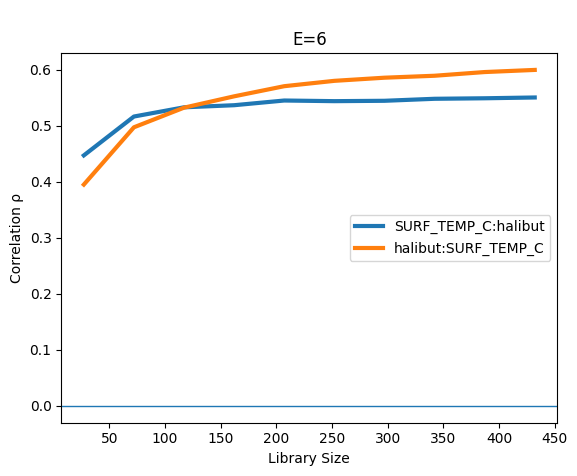

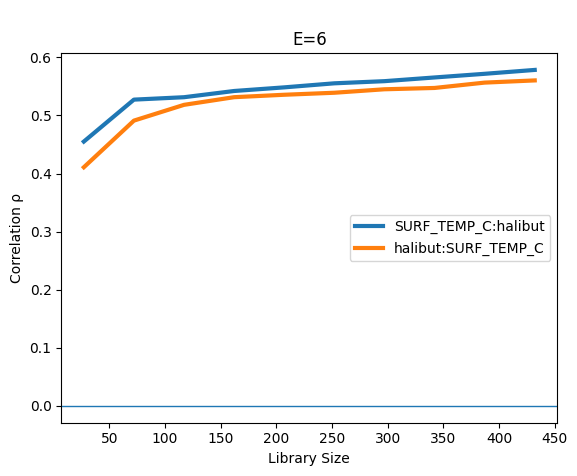

In [100]:
#interaction = interactions[1000] #100
df = data.copy()
A       = 'SURF_TEMP_C' #interaction[1]
B       = 'halibut' #interaction[0]

E, tau, theta = find_best_param(
    df, A, B,
    E_range=Erange,
    tau_range=taurange,
    theta_range=thetarange,
    Tp=1
)
E    = 6
tau  = -2
#theta = float(2)
Tp = 1

t0 = time.time()

libsize_small, libsize_large = int(round( 0.05*len(df) )), int(round( 0.8*len(df) )) # 10% to 80% libsizes of df
libsize_inc = max(1, int(round((libsize_large - libsize_small)/9))) # 10 point increment
libsizes = f"{libsize_small} {libsize_large} {libsize_inc}"

excluR = np.abs(E * tau)

# Original
#rho, auc, rho_conv, convergence = ccm_test(df, A, B, E=3, tau=-1, theta=theta, Tp=1, exclusionRadius=12, libsizes=libsizes, convergence=True)
out = CCM(
    dataFrame=df,
    columns=A, target=B, 
    libSizes=libsizes,
    sample=100,
    exclusionRadius=12,#excluR,
    E=E, tau=tau, Tp=Tp,
    includeData=True,
    showPlot=True
)

# Surrogates
xs, ys = surrogates_seasonal_pair(df[A], df[B], ns=1, mode="within_phase", period=12, verbose=False)
df_surr = df.copy()
df_surr[A] = xs[0]  # keeps original 'A' intact; 'A_surr' holds the shuffled series
df_surr[B] = ys[0]  # keeps original 'A' intact; 'A_surr' holds the shuffled series

#rho_trial, auc_trial, rhoconv_trial, conv_trial] = ccm_test(df_surr, A, B, E=3, tau=-1, theta=theta, Tp=1, exclusionRadius=12, libsizes=libsizes, convergence=True)
out_trial = CCM(
    dataFrame=df_surr,
    columns=A, target=B, 
    libSizes=libsizes,
    sample=100,
    exclusionRadius=12,#excluR,
    E=E, tau=tau, Tp=Tp,
    includeData=True,
    showPlot=True
)

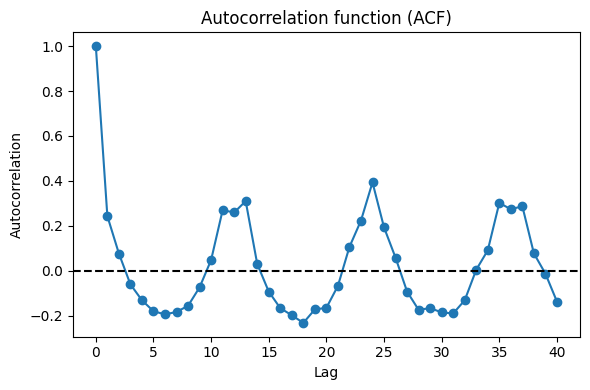

In [78]:
def autocorrelation(x, max_lag):
    """
    Return autocorrelation for lags 0..max_lag.
    x: 1D array-like time series
    """
    x = np.asarray(x)
    x = x - np.mean(x)          # center
    n = len(x)
    result = np.empty(max_lag + 1)

    # variance (lag 0)
    var = np.sum(x * x)

    for lag in range(max_lag + 1):
        # dot product of overlapping parts
        num = np.dot(x[:n-lag], x[lag:])
        # "unbiased" normalization by (n - lag)
        result[lag] = num / ((n - lag) * (var / n))

    return result

# Example:
ts = df_surr[B]
acf_vals = autocorrelation(ts, max_lag=40)

max_lag = len(acf_vals) - 1
lags = np.arange(max_lag + 1)

plt.figure(figsize=(6, 4))
plt.plot(lags, acf_vals, marker="o")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation function (ACF)")
plt.tight_layout()
plt.show()

In [ ]:
#interaction = interactions[1000] #100
df = data.copy()
A       = 'SURF_TEMP_C' #interaction[0]
B       = 'crab_rock' #interaction[1]
#E    = 3
#tau  = -2
#theta = float(2)
#Tp = 1

E, tau, theta = find_best_param(
    df, A, B,
    E_range=Erange,
    tau_range=taurange,
    theta_range=thetarange,
    Tp=1
)

t0 = time.time()

libsize_small, libsize_large = int(round( 0.05*len(df) )), int(round( 0.8*len(df) )) # 10% to 80% libsizes of df
libsize_inc = max(1, int(round((libsize_large - libsize_small)/9))) # 10 point increment
libsizes = f"{libsize_small} {libsize_large} {libsize_inc}"

# Original
rho, auc, rho_conv, convergence = ccm_test(df, A, B, E=3, tau=-1, theta=theta, Tp=1, exclusionRadius=12, libsizes=libsizes, convergence=True)

t1 = time.time()
print("Step 1: " + str(round(t1-t0, 2)) + "s" + " (" + str(round((t1-t0) / 60 / 60, 2)) + "h)")
tj = t1

if convergence == True:
    # Surrogates
    num_trials = 100
    rho_trials = np.zeros(num_trials)
    auc_trials = np.zeros(num_trials)
    rhoconv_trials = np.zeros(num_trials)
    conv_trials = np.zeros(num_trials)
    
    for trial in range(num_trials):
        xs, ys = surrogates_seasonal_pair(df[A], df[B], ns=1, mode="within_phase", period=12, verbose=False)
        df_surr = df.copy()
        df_surr[A] = xs[0]  # keeps original 'A' intact; 'A_surr' holds the shuffled series
        df_surr[B] = ys[0]  # keeps original 'A' intact; 'A_surr' holds the shuffled series
    
        rho_trials[trial], auc_trials[trial], rhoconv_trials[trial], conv_trials[trial] = ccm_test(df_surr, A, B, E=3, tau=-1, theta=theta, Tp=1, exclusionRadius=12, libsizes=libsizes, convergence=True)
        ti = time.time()
        print(str(trial) + " (" + str(round(ti-tj, 2)) + " s)")
        tj = ti
    
    t2 = time.time()
    print("Overall: " + str(round(t2-t0, 2)) + "s" + " (" + str(round((t2-t0) / 60 / 60, 2)) + "h)")

else:
    t2 = time.time()
    print("Overall: " + str(round(t2-t0, 2)) + "s" + " (" + str(round((t2-t0) / 60 / 60, 2)) + "h)")

In [ ]:
rho_obs = rho               # scalar
auc_obs = auc               # scalar
conv_obs = convergence      # bool

rho_surr = rho_trials       # shape (n_trials,)
auc_surr = auc_trials       # shape (n_trials,)
conv_surr = conv_trials     # shape (n_trials,), bool

p_rho = empirical_p(rho_obs, rho_surr, tail="greater")
p_auc = empirical_p(auc_obs, auc_surr, tail="greater")


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ρ
ax = axes[0]
ax.hist(rho_surr, bins=30, density=True, alpha=0.7)
ax.axvline(rho_obs, linestyle="--", color="black")
ax.set_title(f"rho; p = {p_rho:.3f}")
ax.set_xlabel("rho")
ax.set_ylabel("density")

# AUC
ax = axes[1]
ax.hist(auc_surr, bins=30, density=True, alpha=0.7)
ax.axvline(auc_obs, linestyle="--", color="black")
ax.set_title(f"AUC; p = {p_auc:.3f}")
ax.set_xlabel("AUC")

plt.tight_layout()
plt.show()